In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from PIL import Image
from scipy.io import loadmat


np.random.seed(7)

In [ ]:
def gaussian(x, mu, sigma):
    return 1./(np.sqrt(2.*np.pi)*sigma)*np.exp(-np.power((x - mu)/sigma, 2.)/2)

# 1. EM Algorithm

In [ ]:
class EM:
    def __init__(self, K, P, GMM, eps=0.01):
        self.K = K
        self.P = P
        self.eps = eps
        self.mu = GMM[0]
        self.sigma = GMM[1]

    def fit(self, data, max_iter=1000):
      N = data.shape[0]

      for iter in range(max_iter):
        # Expectation step
        G = gaussian(data, self.mu, self.sigma)
        PG = self.P * G
        F = PG.sum(axis=1, keepdims=True) + 1e-8 
        Z = PG / F  # sample-class probabilities
        
        # Maximization step
        sigma_Z_X = (Z * data).sum(axis=0, keepdims=True)
        sigma_Z = Z.sum(axis=0, keepdims=True) + 1e-8 
        mu = sigma_Z_X / sigma_Z # new means

        X_mu_sq = np.power(data - mu, 2)
        sigma_Z_X_mu_sq = (Z * X_mu_sq).sum(axis=0, keepdims=True)
        sigma = np.sqrt(sigma_Z_X_mu_sq / sigma_Z) # new variances
        P = sigma_Z / N # new class probabilities

        # stopping condition
        PI_mu = np.prod(np.abs(mu - self.mu), keepdims=True)
        PI_sig = np.prod(np.abs(sigma - self.sigma), keepdims=True)
        PI_P = np.prod(P)
        if(PI_mu < self.eps and PI_sig < self.eps and PI_P < self.eps):
          print(f"Convergence in {iter + 1} iterations.")
          break
        else:
          # parameter update
          self.mu = mu
          self.sigma = sigma
          self.P = P

    def cluster(self, data):
      G = gaussian(data.reshape(-1, 1), self.mu, self.sigma)
      return np.argmax(G, axis=1).reshape(data.shape) 

# 2. EM on Dataset 3

## Confusuion Matrix Helper

In [ ]:
def dataset3_confusion(y_true, y_pred, visualize):

  # correct types
  y_true = y_true.astype('int64')
  y_pred = y_pred.astype('int64')

  # all possible label permutations (actual to predicted)
  permutations = list(itertools.permutations([0, 1, 2, 3]))

  max_arg = 0
  max_trace = 0

  # initialize confusion matriices
  confusion = np.zeros((len(permutations), 4, 4));

  for perm_idx, perm in enumerate(permutations):

    # map predicted to actual labels
    inv_perm = {}
    for i, elem in enumerate(perm):
      inv_perm[elem] = i

    # populate confusuion matrix
    for actual, predicted in zip(y_true, y_pred):
      confusion[perm_idx, actual, inv_perm[predicted]] += 1
    
    trace = np.trace(confusion[perm_idx])
    
    if trace > max_trace:
      max_arg = perm_idx
      max_trace = trace

  # recover the best confusion matrix
  if(visualize):
    confusion_df = pd.DataFrame(confusion[max_arg], [0, 1, 2, 3], [0, 1, 2, 3])
    confusion_df.index.name = 'Actual'
    confusion_df.columns.name = 'Predicted'
    sns.set(font_scale=1.5)
    sns.heatmap(confusion_df,cmap="vlag", annot=True, annot_kws={"size": 20}, fmt='g')
    plt.show()

  return confusion[max_arg]

## Dataset Loading 

In [ ]:
# read the images
orig = plt.imread('Data/testGrayImage.png')
low = plt.imread('Data/testGrayImage_low.png')
mid = plt.imread('Data/testGrayImage_mid.png')
hi = plt.imread('Data/testGrayImage_hi.png')

# combine images in one array
dataset3 = np.array([orig, low, mid, hi]) * 255

dataset3.shape
# ground truth
y_true = np.zeros((512, 512))
y_true[:256, :256] = 0
y_true[:256, 256:] = 2
y_true[256:, :256] = 1
y_true[256:, 256:] = 3
y_true = y_true.reshape(-1)

## Parameter Initialization

In [ ]:
K = 4
P = np.array([1/K] * K)
GMM = np.array([[25., 90., 160., 240.],[1., 1., 1., 1.]])
eps = 0.01

## Applying EM on TestGrayImage_low

In [ ]:
model = EM(K, P, GMM, eps)
model.fit(dataset3[1].reshape(-1, 1))

# GMM parameters
print(f"GMM means: {model.mu.astype('uint8')}")
print(f"GMM variances: {model.sigma.astype('uint8')}")
print(f"Class Probs: {model.P}")

Convergence in 9 iterations.
GMM means: [[ 49  98 170 209]]
GMM variances: [[ 9 10 28  4]]
Class Probs: [[0.24603863 0.23683845 0.49249305 0.02462723]]


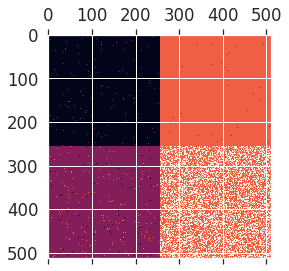

In [ ]:
# classification matrix
y_pred = model.cluster(dataset3[1])
plt.matshow(y_pred);

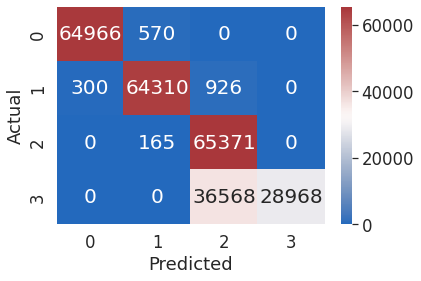

Total accuracy = 85.30235290527344%
Class 1 accuracy = 99.1302490234375%
Class 2 accuracy = 98.1292724609375%
Class 3 accuracy = 99.74822998046875%
Class 4 accuracy = 44.20166015625%


In [ ]:
# Confusion matrix
cf = dataset3_confusion(y_true, y_pred.reshape(-1), True);
cf_trace = np.trace(cf)
print(f"Total accuracy = {(cf_trace / (512 * 512)) * 100}%")
print(f"Class 1 accuracy = {(cf[0,0] / ((512 * 512) / 4)) * 100}%")
print(f"Class 2 accuracy = {(cf[1,1] / ((512 * 512) / 4)) * 100}%")
print(f"Class 3 accuracy = {(cf[2,2] / ((512 * 512) / 4)) * 100}%")
print(f"Class 4 accuracy = {(cf[3,3] / ((512 * 512) / 4)) * 100}%")

## Applying EM on TestGrayImage_mid

In [ ]:
model = EM(K, P, GMM, eps)
model.fit(dataset3[2].reshape(-1, 1))

# GMM parameters
print(f"GMM means: {model.mu.astype('uint8')}")
print(f"GMM variances: {model.sigma.astype('uint8')}")
print(f"Class Probs: {model.P}")

Convergence in 10 iterations.
GMM means: [[ 45  94 163 206]]
GMM variances: [[13 21 29  9]]
Class Probs: [[0.19950154 0.29357962 0.4042322  0.10268401]]


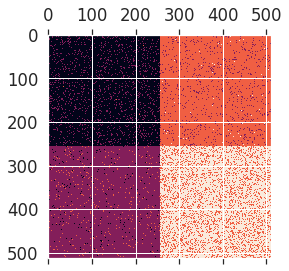

In [ ]:
# classification matrix
y_pred = model.cluster(dataset3[2])
plt.matshow(y_pred);

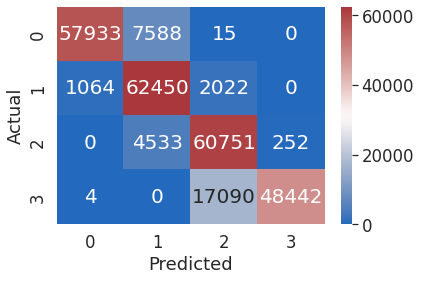

Total accuracy = 87.5762939453125%
Class 1 accuracy = 88.39874267578125%
Class 2 accuracy = 95.2911376953125%
Class 3 accuracy = 92.69866943359375%
Class 4 accuracy = 73.9166259765625%


In [ ]:
# Confusion matrix
cf = dataset3_confusion(y_true, y_pred.reshape(-1), True);
cf_trace = np.trace(cf)
print(f"Total accuracy = {(cf_trace / (512 * 512)) * 100}%")
print(f"Class 1 accuracy = {(cf[0,0] / ((512 * 512) / 4)) * 100}%")
print(f"Class 2 accuracy = {(cf[1,1] / ((512 * 512) / 4)) * 100}%")
print(f"Class 3 accuracy = {(cf[2,2] / ((512 * 512) / 4)) * 100}%")
print(f"Class 4 accuracy = {(cf[3,3] / ((512 * 512) / 4)) * 100}%")

## Applying EM on TestGrayImage_hi

In [ ]:
model = EM(K, P, GMM, eps)
model.fit(dataset3[3].reshape(-1, 1))

# GMM parameters
print(f"GMM means: {model.mu.astype('uint8')}")
print(f"GMM variances: {model.sigma.astype('uint8')}")
print(f"Class Probs: {model.P}")

Convergence in 9 iterations.
GMM means: [[ 40  92 162 213]]
GMM variances: [[17 25 27 17]]
Class Probs: [[0.16868823 0.33268143 0.37943958 0.11918802]]


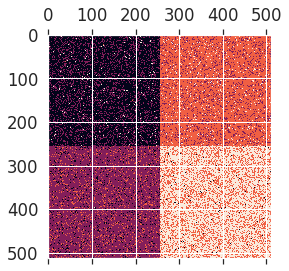

In [ ]:
# classification matrix
y_pred = model.cluster(dataset3[3])
plt.matshow(y_pred);

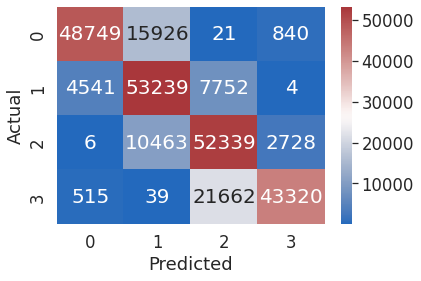

Total accuracy = 75.39634704589844%
Class 1 accuracy = 74.38507080078125%
Class 2 accuracy = 81.23626708984375%
Class 3 accuracy = 79.86297607421875%
Class 4 accuracy = 66.10107421875%


In [ ]:
# Confusion matrix
cf = dataset3_confusion(y_true, y_pred.reshape(-1), True);
cf_trace = np.trace(cf)
print(f"Total accuracy = {(cf_trace / (512 * 512)) * 100}%")
print(f"Class 1 accuracy = {(cf[0,0] / ((512 * 512) / 4)) * 100}%")
print(f"Class 2 accuracy = {(cf[1,1] / ((512 * 512) / 4)) * 100}%")
print(f"Class 3 accuracy = {(cf[2,2] / ((512 * 512) / 4)) * 100}%")
print(f"Class 4 accuracy = {(cf[3,3] / ((512 * 512) / 4)) * 100}%")